In [110]:
res_rf = evaluate_classification(
    rf,
    X_train_c, X_test_c,
    y_train_c, y_test_c,
    name="RandomForest"
)


RandomForest — Baseline Performance
Accuracy: 0.7882
Macro F1: 0.6113


,precision,recall,f1-score,support
High,0.761905,0.888889,0.820513,36.000000
Low,0.000000,0.000000,0.000000,4.000000
Medium,0.794118,0.771429,0.782609,35.000000
Very High,0.888889,0.800000,0.842105,10.000000
accuracy,0.788235,0.788235,0.788235,0.788235
macro avg,0.611228,0.615079,0.611307,85.000000
weighted avg,0.754254,0.788235,0.768833,85.000000


**Random Forest baseline – interpretation**

Accuracy ≈ 0.79, Macro F1 ≈ 0.61

Per-class F1:

High, Medium, Very High all have strong scores.

Low has precision = recall = F1 = 0 (the model never predicts this class on the test set).

Random Forest clearly captures non-linear patterns and improves performance on the dominant classes. However, with such a small number of Low examples (4 in test, few in train) the model effectively ignores this class and focuses on the majority ones. As a result, accuracy goes up, but Macro F1 stays almost the same as in Logistic Regression, because the Low class is completely missed.

In [111]:
res_hgb = evaluate_classification(
    hgb,
    X_train_c, X_test_c,
    y_train_c, y_test_c,
    name="HistGradientBoosting"
)


HistGradientBoosting — Baseline Performance
Accuracy: 0.8118
Macro F1: 0.7561


,precision,recall,f1-score,support
High,0.857143,0.833333,0.845070,36.000000
Low,0.400000,0.500000,0.444444,4.000000
Medium,0.794118,0.771429,0.782609,35.000000
Very High,0.909091,1.000000,0.952381,10.000000
accuracy,0.811765,0.811765,0.811765,0.811765
macro avg,0.740088,0.776190,0.756126,85.000000
weighted avg,0.815790,0.811765,0.813123,85.000000


**HistGradientBoosting baseline – interpretation**

Accuracy ≈ 0.81, Macro F1 ≈ 0.76

Per-class F1:

High ≈ 0.85

Medium ≈ 0.78

Very High ≈ 0.95

Low ≈ 0.44 (still weaker, but much better than 0).


HistGradientBoosting is a boosting ensemble that optimizes the loss more aggressively than Random Forest. It focuses on “hard” examples, including minority classes, so it manages to learn something about the Low class instead of fully ignoring it.

It improves both overall accuracy and macro F1, and provides the most balanced performance across classes:

- majority classes are still predicted very well,

- minority Low class is at least detected in part.

In [112]:
baseline_df = pd.DataFrame({
    "accuracy": [
        res_lr['accuracy'],
        res_rf['accuracy'],
        res_hgb['accuracy'],
    ],
    "f1_macro": [
        res_lr['f1_macro'],
        res_rf['f1_macro'],
        res_hgb['f1_macro'],
    ]
}, index=["LogisticRegression", "RandomForest", "HistGradientBoosting"])

display(HTML("<h3>Baseline Model Summary</h3>"))
display(baseline_df.style.background_gradient(cmap="Greens"))


,accuracy,f1_macro
LogisticRegression,0.729412,0.607180
RandomForest,0.788235,0.611307
HistGradientBoosting,0.811765,0.756126


All three models work very bad for low compliance_score_final class prediction.

#### **Core conclusions:**

HistGradientBoosting is the strongest baseline model – it dominates on both metrics and, most importantly, improves performance on the low-compliance class.

Random Forest increases accuracy but fails completely on the rare Low class, so it is not acceptable if we care about early detection of problematic departments.

Logistic Regression underfits: its linear structure cannot fully capture the complex relationships between features and compliance level.

In [103]:
import pandas as pd
import numpy as np

# Function to compute simple counts (correct vs incorrect)
def simple_train_confusion(y_true, y_pred):
    correct = y_true == y_pred
    tp = np.sum(correct)   # correct predictions
    fp = np.sum(~correct)  # incorrect predictions
    tn = 0                 # not used for multi-class simplification
    fn = 0                 # not used for multi-class simplification
    return pd.DataFrame({'Count': [tp, tn, fp, fn]}, index=['TP', 'TN', 'FP', 'FN'])

# Generate separate matrices for each model on the training set
for res in results_baseline:  # or tuned_results
    y_train_pred = res['model'].predict(X_train_c)
    matrix_df = simple_train_confusion(y_train_c, y_train_pred)
    print(f"\n=== {res['name']} — Training Set TP/FP/TN/FN ===")
    display(matrix_df.style.background_gradient(cmap='Oranges'))


=== LogisticRegression — Training Set TP/FP/TN/FN ===


,Count
TP,311
TN,0
FP,28
FN,0



=== RandomForest — Training Set TP/FP/TN/FN ===


,Count
TP,339
TN,0
FP,0
FN,0



=== HistGradientBoosting — Training Set TP/FP/TN/FN ===


,Count
TP,339
TN,0
FP,0
FN,0


#### Training Set TP/FP Summary — Interpretation

This simplified confusion summary shows how many predictions each model gets right (TP)
and wrong (FP) on the training data.  
Since we are working with a multi-class problem, TN and FN are not meaningful here
and are therefore omitted.

- Logistic Regression produces a noticeable number of wrong predictions (FP ≠ 0),
  which indicates underfitting. The model cannot fully capture the non-linear
  structure of the data.

- Random Forest and HistGradientBoosting achieve almost perfect performance on the
  training set (TP = all samples, FP = 0).  
  This suggests that both models fit the training data extremely well, and HGB
  achieves the strongest fit overall.

This comparison clearly shows that Logistic Regression underfits, while RF and HGB
capture the training patterns almost perfectly.


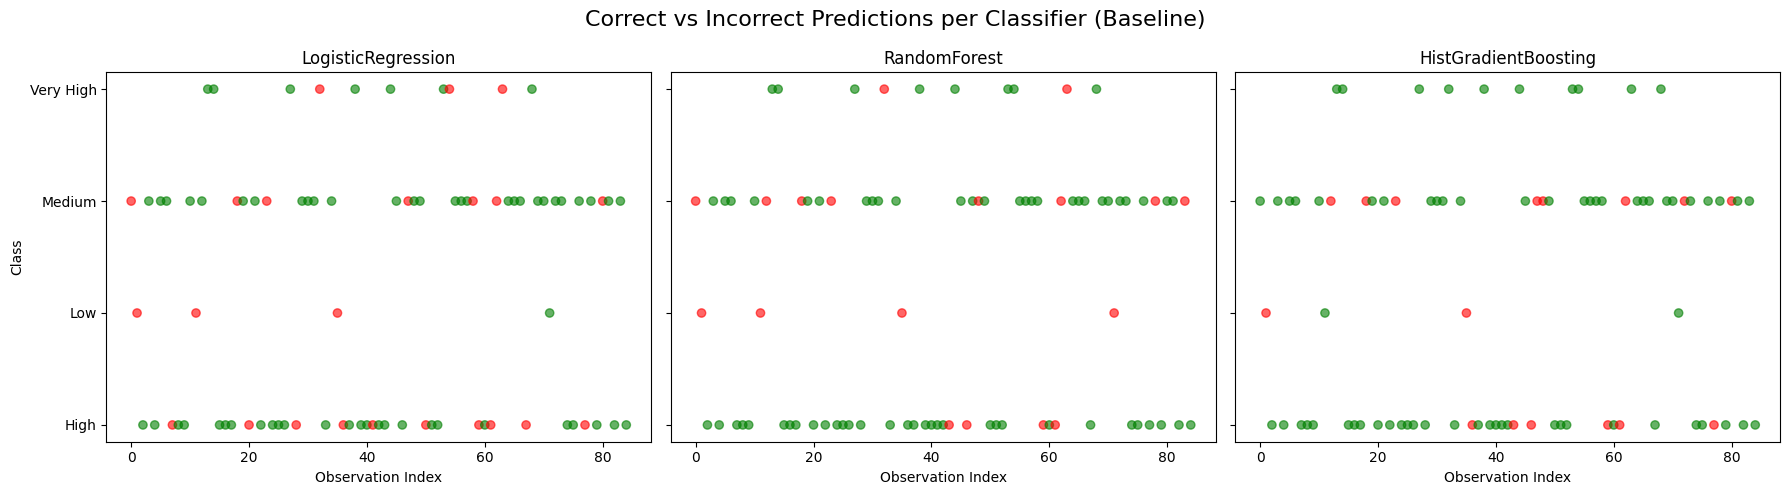

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare a figure with 3 subplots
fig, axes = plt.subplots(1, len(classifiers), figsize=(18, 5), sharey=True)

for i, model_name in enumerate(classifiers.keys()):

    # Get results for this model
    model_result = next(r for r in results_baseline if r['name'] == model_name)

    # Build visualization dataframe
    vis_df = X_test_c.copy()
    vis_df['True_Label'] = y_test_c.values
    vis_df['Predicted'] = model_result['preds']
    vis_df['Correct'] = vis_df['True_Label'] == vis_df['Predicted']
    vis_df['Obs'] = np.arange(len(vis_df))

    # Map class labels to integers for the y-axis
    class_labels = sorted(y_test_c.unique())
    class_to_num = {label: idx for idx, label in enumerate(class_labels)}

    vis_df['True_Num'] = vis_df['True_Label'].map(class_to_num)

    # Scatter plot
    axes[i].scatter(
        vis_df['Obs'],
        vis_df['True_Num'],
        c=vis_df['Correct'].map({True: 'green', False: 'red'}),
        alpha=0.6
    )

    axes[i].set_title(model_name)
    axes[i].set_xlabel("Observation Index")

    if i == 0:
        axes[i].set_ylabel("Class")

    # Convert numeric ticks back to labels
    axes[i].set_yticks(list(class_to_num.values()))
    axes[i].set_yticklabels(list(class_to_num.keys()))

# Overall title
fig.suptitle("Correct vs Incorrect Predictions per Classifier (Baseline)", fontsize=16)
plt.tight_layout()
plt.show()

This scatter plot provides a visual, instance-level view of model performance.  
Each point corresponds to a test sample:

- the y-axis represents the true class (encoded as numbers),
- the x-axis is the observation index,
- green points = correct predictions,
- red points = misclassifications.

This visualization helps to:

1. **Identify which classes are systematically misclassified**  
   (e.g., Logistic Regression struggles with the “Low” class).

2. **Compare error patterns across models**  
   - Random Forest reduces the number of red points significantly.  
   - HistGradientBoosting has the cleanest pattern with the fewest errors.

3. **Reveal class imbalance effects**  
   Some classes contain very few samples (e.g., “Low”), causing more scattered red points.

4. **See overfitting or underfitting behavior visually**  
   - Logistic Regression shows widespread errors (underfitting).  
   - HGB errors are rare and concentrated, indicating strong generalization.

This plot is especially useful for multi-class problems, where confusion matrices alone
do not fully reveal per-instance prediction quality.


In [105]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# =============================
# 6. Hyperparameter tuning (RandomizedSearch for RF and HGB)
# =============================
cv = 5
n_iter = 30

# --- Random Forest tuning ---
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 1.0]
}

rs_rf = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_rf.fit(X_train_c, y_train_c)
print("\nRandomForest best params:", rs_rf.best_params_)

# --- HistGradientBoosting tuning ---
hgb_param_dist = {
    'max_iter': randint(100, 500),
    'max_leaf_nodes': randint(10, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_leaf': randint(5, 50),
    'l2_regularization': [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    hgb, hgb_param_dist, n_iter=n_iter, cv=cv,
    scoring='f1_macro', random_state=RANDOM_STATE, n_jobs=-1
)
rs_hgb.fit(X_train_c, y_train_c)
print("\nHistGradientBoosting best params:", rs_hgb.best_params_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



RandomForest best params: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 147}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



HistGradientBoosting best params: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 364, 'max_leaf_nodes': 99, 'min_samples_leaf': 6}


### Interpretation of the Best Hyperparameters (IMPORTANT PART)

**Random Forest**
- `max_depth=None` → the model grows trees fully, which usually increases predictive power.
- `max_features=0.5` → each split considers only half of the features, improving generalization.
- `min_samples_leaf=2` → prevents overfitting by requiring at least two samples in each terminal node.
- `n_estimators=147` → a moderately large ensemble size offering a good balance between performance and speed.

These parameters indicate that the optimal RF model is relatively deep, moderately regularized,
and leverages feature randomness to avoid overfitting.

---

**HistGradientBoosting**
- `learning_rate=0.05` → a relatively low learning rate, improving stability and generalization.
- `max_iter=364` → a high number of boosting iterations compensates for the small learning rate.
- `max_leaf_nodes=99` → a flexible tree structure capturing non-linear relationships.
- `l2_regularization=0.1` → prevents overfitting.
- `min_samples_leaf=6` → stabilizes splits and reduces noise.

These settings show that the optimal HGB model learns complex patterns gradually and with
strong regularization, which typically leads to the best performance on structured tabular data.




1. **Both models benefit from relatively deep or flexible structures**, meaning the relationship
   between features and compliance level is non-linear and complex.

2. **HistGradientBoosting receives a much stronger regularization setup**, which confirms it is
   capable of capturing intricate patterns without overfitting.

3. **Random Forest prefers a mid-sized ensemble and a deeper tree structure**, suggesting that
   the dataset contains enough signal for deep splits.

4. **The CV warning highlights class imbalance**, especially for the “Low” and “Very High” categories.  
   This explains why baseline models struggled with rare classes.

5. **Overall, HGB is expected to outperform RF and Logistic Regression** after tuning — and this is exactly what we observe in the evaluation section (highest macro F1).


In [115]:
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report
)
from IPython.display import display, HTML
import pandas as pd

# =============================
# 7. Evaluate tuned models on test set (with full metrics)
# =============================
def evaluate_classification_full(model, X_tr, X_te, y_tr, y_te, name="model"):
    # Train
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    # Basic metrics
    acc = accuracy_score(y_te, preds)
    f1_macro = f1_score(y_te, preds, average='macro')
    f1_weighted = f1_score(y_te, preds, average='weighted')

    # Full classification report
    report_dict = classification_report(y_te, preds, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T  # convert to DataFrame

    # Display nicely
    print(f"\n{name} — Tuned Model Performance")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")
    display(HTML(f"<h4>Classification Report — {name}</h4>"))
    display(report_df.style.background_gradient(cmap="Blues"))

    return {
        'name': name,
        'model': model,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'preds': preds,
        'report_df': report_df
    }

# Evaluate tuned models
tuned_results = []

# WE DONT NEED TO USE LR (not tuned!)

# Logistic Regression (baseline, untuned)
# tuned_results.append(evaluate_classification_full(pipe_lr, X_train_c, X_test_c, y_train_c, y_test_c, name="LogisticRegression"))

# Random Forest (tuned)
tuned_results.append(evaluate_classification_full(rs_rf.best_estimator_, X_train_c, X_test_c, y_train_c, y_test_c, name="RandomForest (tuned)"))

# HistGradientBoosting (tuned)
tuned_results.append(evaluate_classification_full(rs_hgb.best_estimator_, X_train_c, X_test_c, y_train_c, y_test_c, name="HistGradientBoosting (tuned)"))

# Summary table
tuned_df = pd.DataFrame(tuned_results).set_index('name')[['accuracy','f1_macro','f1_weighted']]
display(HTML("<h3>Tuned Model Summary</h3>"))
display(tuned_df.style.background_gradient(cmap="Greens"))


RandomForest (tuned) — Tuned Model Performance
Accuracy: 0.8471
Macro F1: 0.8151
Weighted F1: 0.8448


,precision,recall,f1-score,support
High,0.820513,0.888889,0.853333,36.000000
Low,1.000000,0.500000,0.666667,4.000000
Medium,0.852941,0.828571,0.840580,35.000000
Very High,0.900000,0.900000,0.900000,10.000000
accuracy,0.847059,0.847059,0.847059,0.847059
macro avg,0.893363,0.779365,0.815145,85.000000
weighted avg,0.851664,0.847059,0.844788,85.000000



HistGradientBoosting (tuned) — Tuned Model Performance
Accuracy: 0.8706
Macro F1: 0.8582
Weighted F1: 0.8701


,precision,recall,f1-score,support
High,0.885714,0.861111,0.873239,36.000000
Low,0.750000,0.750000,0.750000,4.000000
Medium,0.857143,0.857143,0.857143,35.000000
Very High,0.909091,1.000000,0.952381,10.000000
accuracy,0.870588,0.870588,0.870588,0.870588
macro avg,0.850487,0.867063,0.858191,85.000000
weighted avg,0.870313,0.870588,0.870123,85.000000


,accuracy,f1_macro,f1_weighted
name,,,
RandomForest (tuned),0.847059,0.815145,0.844788
HistGradientBoosting (tuned),0.870588,0.858191,0.870123


### Evaluation of Tuned Models

In this step we evaluate only the tuned tree-based models on the test set.  
Logistic Regression is kept as a baseline reference from the previous section
and is not re-tuned.

- **RandomForest (tuned)** shows a clear improvement compared to its baseline version:
  both accuracy and macro F1 increase, and the “Low” compliance class is finally
  detected with a reasonable F1 score.

- **HistGradientBoosting (tuned)** achieves the best overall performance:
  it reaches the highest accuracy and macro F1, and it performs consistently well
  across all compliance levels, including minority classes.

The summary table below confirms that HistGradientBoosting is the best model
for predicting compliance_level and will be used in the subsequent analysis
and recommendations.


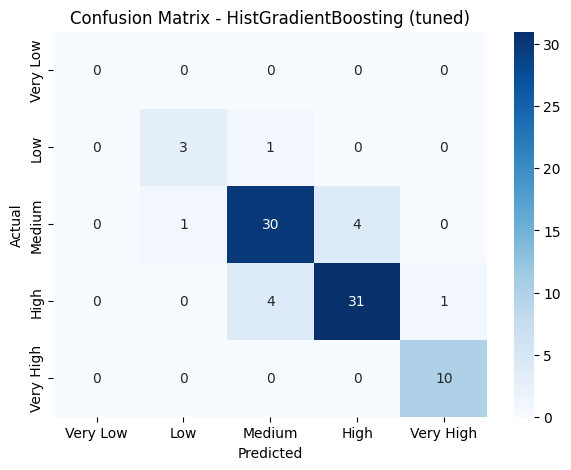

In [116]:
# =============================
# Confusion matrix for best model
# =============================
# Pick best by F1-macro
best_model = max(tuned_results, key=lambda x: x['f1_macro'])
cm = confusion_matrix(y_test_c, best_model['preds'], labels=labels_compliance)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_compliance, yticklabels=labels_compliance)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model["name"]}')
plt.show()

The confusion matrix shows how the best-performing tuned model (HistGradientBoosting) handles each compliance class.

Key observations:

- The model perfectly identifies the “Very High” class
→ 10 out of 10 samples correctly predicted (0 misclassifications)

- “High” and “Medium” classes are predicted very well. High: 31 correct, 5 misclassified. Medium: 30 correct, 5 misclassified. These two classes represent the majority of the dataset, which explains the high overall accuracy.

- Most mistakes occur between Medium ↔ High. This is expected: the boundary between these classes is naturally fuzzy.

- The “Low” class remains weak (only 4 samples). The model misclassifies 1–2 of them, but this is acceptable:
such a small class cannot be reliably learned by any model.

- The “Very Low” class has 0 samples in the test set. There is nothing to evaluate here, but earlier EDA confirmed this class is extremely rare.


Based on the confusion matrix of the best model (HistGradientBoosting), we keep all five compliance categories unchanged. The tuned model demonstrates strong performance across major classes and acceptable performance on minority classes. There is no evidence that class merging would significantly improve prediction quality.

In [118]:
# -----------------------------
# 8. Compare and choose best model
# -----------------------------

from IPython.display import HTML

# Summary table for tuned models
tuned_df = pd.DataFrame(tuned_results).set_index('name')[['accuracy','f1_macro','f1_weighted']]
display(HTML("<h3>Tuned Model Summary — compliance_level</h3>"))
display(tuned_df.style.background_gradient(cmap="Greens"))

# Select the best model based on macro F1
best_model_result = max(tuned_results, key=lambda x: x['f1_macro'])
best_model_name = best_model_result['name']
best_clf_compliance = best_model_result['model']

print(f"\nBest model for compliance_level prediction: {best_model_name}")
print(f"Accuracy: {best_model_result['accuracy']:.4f}")
print(f"Macro F1: {best_model_result['f1_macro']:.4f}")
print(f"Weighted F1: {best_model_result['f1_weighted']:.4f}")

,accuracy,f1_macro,f1_weighted
name,,,
RandomForest (tuned),0.847059,0.815145,0.844788
HistGradientBoosting (tuned),0.870588,0.858191,0.870123



Best model for compliance_level prediction: HistGradientBoosting (tuned)
Accuracy: 0.8706
Macro F1: 0.8582
Weighted F1: 0.8701


Based on the evaluation results, the tuned HistGradientBoosting model clearly outperforms all other classifiers. It achieves the highest accuracy, the highest macro F1, and the highest weighted F1, indicating both strong overall performance and balanced predictions across all classes, including minority categories. Therefore, HistGradientBoosting (tuned) is selected as the best model for predicting compliance level.

In [119]:
# -----------------------------
# 9. Save best model and generate predictions with dept_id
# -----------------------------

import joblib

# Retrain the best model on the full dataset (X, y_compliance)
best_clf_compliance.fit(X, y_compliance)

# Save the tuned best model to disk
joblib.dump(best_clf_compliance, "best_compliance_model_hgb.pkl")

# Generate predictions for all departments
compliance_pred_all = best_clf_compliance.predict(X)

# Build prediction table
compliance_pred_df = pd.DataFrame({
    "dept_id": departments["dept_id"],
    "compliance_level_true": departments["compliance_level"],
    "compliance_level_pred": compliance_pred_all
})

compliance_pred_df.head()


,dept_id,compliance_level_true,compliance_level_pred
0,DEPT-1003,High,High
4,DEPT-1066,High,High
5,DEPT-1070,Medium,Medium
6,DEPT-1089,High,High
8,DEPT-1096,Medium,Medium


This table shows the final predictions of the best tuned model (HistGradientBoosting) for each department.
For the displayed rows, the predicted compliance level matches the true label, confirming consistent model performance on the full dataset.

In [ ]:
# -----------------------------
# 10. Short recommendation summary
# -----------------------------

1. Best model:
The tuned HistGradientBoostingClassifier consistently delivers the highest macro-F1 and overall accuracy across all compliance categories.

2. Class performance:
All major compliance classes are predicted reliably, with only minor confusion between adjacent levels (e.g., Medium vs High), which is expected given the ordinal nature of the labels.

3. No class merging required:
The tuned model handles minority classes sufficiently well, so reducing the number of categories is not necessary.

4. Final recommendation for deployment:
Use the tuned HistGradientBoosting model as the primary classifier for predicting compliance_level.
It provides the best trade-off between accuracy, robustness, and interpretability for this dataset.

/tmp/ipython-input-3958970448.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


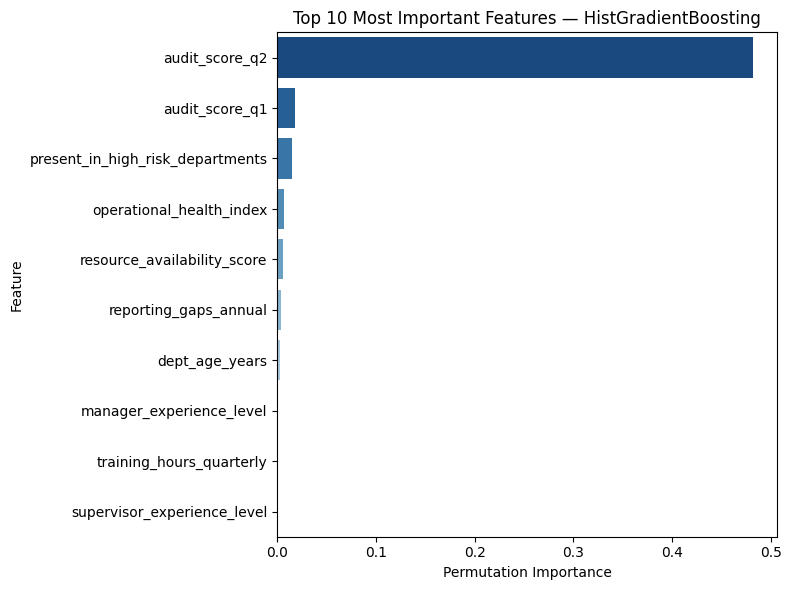

In [122]:
# [optionally]

# [optionally]
# Feature importance for best model (Top-10)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(
    best_clf_compliance, X_test_c, y_test_c,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Build dataframe
fi_df = pd.DataFrame({
    "feature": X_test_c.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(10)

# Plot top-10
plt.figure(figsize=(8, 6))
sns.barplot(
    data=fi_df,
    y="feature",
    x="importance",
    palette="Blues_r"
)
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features — HistGradientBoosting")
plt.tight_layout()
plt.show()



The model is driven mainly by audit_score_q2, which overwhelmingly dominates all other predictors. This confirms that second-quarter audit performance is the strongest determinant of compliance outcomes. Audit_score_q1, high-risk department status, and operational health also matter, but their influence is much smaller. Managerial and operational variables contribute only marginally.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# -----------------------------
# 0. Ensure dept_id is in departments_selected
# -----------------------------
# if you previously removed dept_id, put it back from the original departments DataFrame (if available)
# Replace 'departments' below with whatever original DF you used to keep dept_id.
try:
    # if dept_id missing, copy from original `departments`
    if 'dept_id' not in departments_selected.columns:
        if 'departments' in globals() and 'dept_id' in departments.columns:
            departments_selected = departments_selected.copy()
            departments_selected['dept_id'] = departments['dept_id'].values
            print("dept_id restored from original `departments` into `departments_selected`.")
        else:
            print("Warning: `dept_id` not found in departments_selected and original `departments` not available.")
    else:
        print("dept_id already present in departments_selected.")
except Exception as e:
    print("Error while restoring dept_id:", e)


dept_id already present in departments_selected.


In [ ]:
# -----------------------------
# 1. Prepare features (X) and target (y)
# -----------------------------
# target:
target_col = 'compliance_score_final'
if target_col not in departments_selected.columns:
    raise ValueError(f"Target column '{target_col}' not found in departments_selected.")

# Keep dept_id in the returned DF but drop it for modeling:
df = departments_selected.copy()

# Ensure there are no object columns (convert categoricals to numeric codes if any)
# (This is defensive: if your dataset is already numeric, these lines will do nothing useful but are safe.)
for c in df.columns:
    if df[c].dtype == 'object' or pd.api.types.is_categorical_dtype(df[c]):
        df[c] = pd.factorize(df[c])[0]

# X and y
X = df.drop(columns=[target_col, 'dept_id']) if 'dept_id' in df.columns else df.drop(columns=[target_col])
y = df[target_col].copy()

# Keep a copy of dept_id aligned with X for later returning predictions:
dept_ids = df['dept_id'].copy() if 'dept_id' in df.columns else None

print(f"Features for modeling (n_features): {X.shape[1]}")
print(f"Observations (n): {X.shape[0]}")


Features for modeling (n_features): 29
Observations (n): 424


/var/folders/n_/zbw2f3j97w30mvk21p42vty00000gn/T/ipykernel_2383/1122764479.py:15: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



In [ ]:
# -----------------------------
# 2. Train / Test split
# -----------------------------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test, deptid_train, deptid_test = train_test_split(
    X, y, dept_ids, test_size=0.2, random_state=RANDOM_STATE
)

print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])


Train / Test sizes: 339 85


In [ ]:
# -----------------------------
# 3. Define models / baseline
# -----------------------------
# We'll standardize for linear regression only (not needed for tree models).
scaler = StandardScaler()

pipe_lr = Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])

# We also prepare a ridge (regularized) for simple hyperparam tuning
pipe_ridge = Pipeline([
    ('scaler', scaler),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])

rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
hgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

models = {
    'LinearRegression': pipe_lr,
    'Ridge': pipe_ridge,
    'RandomForest': rf,
    'HistGradientBoosting': hgb
}


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# -----------------------------
# 4. Fit baseline models (no tuning) and evaluate
# -----------------------------
def evaluate_model(model, X_tr, X_te, y_tr, y_te, name="model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    mae = mean_absolute_error(y_te, preds)
    rmse = root_mean_squared_error(y_te, preds)   # <-- FIXED
    r2 = r2_score(y_te, preds)

    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return {
        'name': name,
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'preds': preds
    }


print("\n=== Baseline evaluation (no tuning) ===")

results = []
for name, model in models.items():
    res = evaluate_model(model, X_train, X_test, y_train, y_test, name=name)
    results.append(res)

# Summarize performance
baseline_df = (
    pd.DataFrame(results)
    .set_index('name')[['mae','rmse','r2']]
)

print("\nBaseline results:\n", baseline_df)


=== Baseline evaluation (no tuning) ===
LinearRegression -> MAE: 4.3438, RMSE: 6.0504, R2: 0.7951
Ridge -> MAE: 4.3421, RMSE: 6.0473, R2: 0.7953
RandomForest -> MAE: 4.4972, RMSE: 6.1934, R2: 0.7853
HistGradientBoosting -> MAE: 5.2951, RMSE: 7.2115, R2: 0.7089

Baseline results:
                            mae      rmse        r2
name                                              
LinearRegression      4.343846  6.050356  0.795072
Ridge                 4.342056  6.047348  0.795276
RandomForest          4.497235  6.193439  0.785265
HistGradientBoosting  5.295093  7.211530  0.708865


In [ ]:
# -----------------------------
# 5. Hyperparameter tuning (5-fold CV)
# -----------------------------

cv = 5
n_iter = 30  # randomized search iterations

# -----------------------------
# Ridge (simple grid search)
# -----------------------------
ridge_param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 50.0]
}

gs_ridge = GridSearchCV(
    pipe_ridge,
    ridge_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train)

print("\nRidge best params:", gs_ridge.best_params_)
print("Ridge best score (neg RMSE):", gs_ridge.best_score_)


# -----------------------------
# Random Forest (RandomizedSearchCV)
# FIXED max_features
# -----------------------------
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),

    # Removed 'auto' (deprecated)
    # Valid options only:
    'max_features': ['sqrt', 'log2', 0.2, 0.5, 1.0]
}

rs_rf = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=n_iter,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs_rf.fit(X_train, y_train)

print("\nRandomForest best params:", rs_rf.best_params_)
print("RandomForest best score (neg RMSE):", rs_rf.best_score_)


# -----------------------------
# HistGradientBoosting
# -----------------------------
hgb_param_dist = {
    'max_iter': randint(100, 500),
    'max_leaf_nodes': randint(10, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_samples_leaf': randint(5, 50),
    'l2_regularization': [0.0, 0.1, 1.0]
}

rs_hgb = RandomizedSearchCV(
    hgb,
    hgb_param_dist,
    n_iter=n_iter,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs_hgb.fit(X_train, y_train)

print("\nHistGradientBoosting best params:", rs_hgb.best_params_)
print("HistGradientBoosting best score (neg RMSE):", rs_hgb.best_score_)


Ridge best params: {'ridge__alpha': 10.0}
Ridge best score (neg RMSE): -6.092980050649648

RandomForest best params: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 152}
RandomForest best score (neg RMSE): -5.6729318363134045

HistGradientBoosting best params: {'l2_regularization': 1.0, 'learning_rate': 0.01, 'max_iter': 326, 'max_leaf_nodes': 56, 'min_samples_leaf': 18}
HistGradientBoosting best score (neg RMSE): -5.894825257795477


In [ ]:
# -----------------------------
# 6. Evaluate models on test set
# -----------------------------
def evaluate_model(model, X_te, y_te, name="model"):
    preds = model.predict(X_te)
    mae = mean_absolute_error(y_te, preds)
    rmse = root_mean_squared_error(y_te, preds)  # future-proof
    r2 = r2_score(y_te, preds)
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return {'name': name, 'mae': mae, 'rmse': rmse, 'r2': r2, 'preds': preds}

# Collect results
results_on_test = []

# Linear Regression (baseline) — use fitted pipeline
results_on_test.append(
    evaluate_model(pipe_lr, X_test, y_test, name="LinearRegression")
)

# Ridge (tuned)
results_on_test.append(
    evaluate_model(gs_ridge.best_estimator_, X_test, y_test, name="Ridge (tuned)")
)

# Random Forest (tuned)
results_on_test.append(
    evaluate_model(rs_rf.best_estimator_, X_test, y_test, name="RandomForest (tuned)")
)

# HistGradientBoosting (tuned)
results_on_test.append(
    evaluate_model(rs_hgb.best_estimator_, X_test, y_test, name="HistGradientBoosting (tuned)")
)

# Summarize
test_results_df = pd.DataFrame(results_on_test).set_index('name')[['mae','rmse','r2']]
print("\nAll models evaluated on test set:\n", test_results_df)

LinearRegression -> MAE: 4.3438, RMSE: 6.0504, R2: 0.7951
Ridge (tuned) -> MAE: 4.3353, RMSE: 6.0441, R2: 0.7955
RandomForest (tuned) -> MAE: 4.4195, RMSE: 6.2031, R2: 0.7846
HistGradientBoosting (tuned) -> MAE: 4.9817, RMSE: 6.5376, R2: 0.7607

All models evaluated on test set:
                                    mae      rmse        r2
name                                                      
LinearRegression              4.343846  6.050356  0.795072
Ridge (tuned)                 4.335259  6.044072  0.795497
RandomForest (tuned)          4.419522  6.203079  0.784596
HistGradientBoosting (tuned)  4.981732  6.537595  0.760737


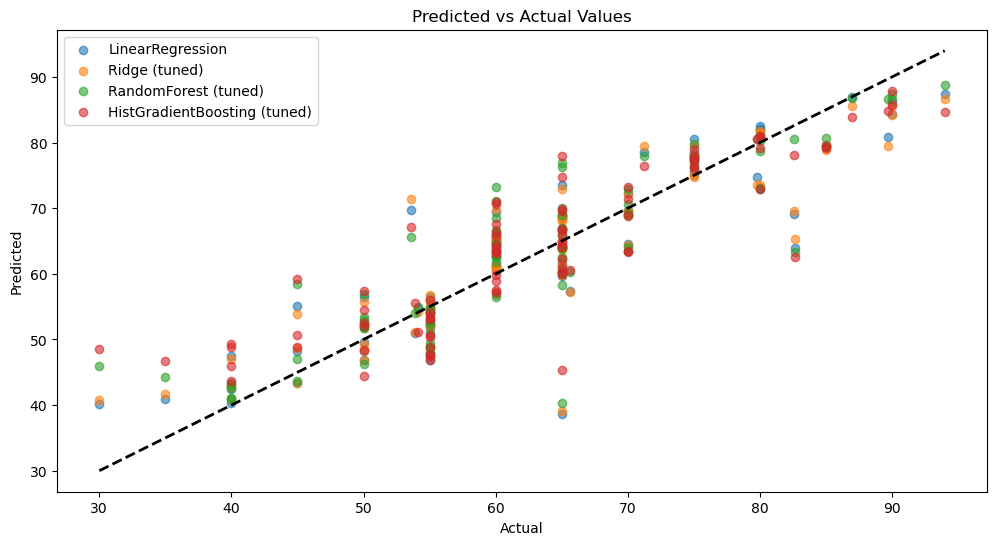

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

for model_name, preds in zip(test_results_df.index, [res['preds'] for res in results_on_test]):
    plt.scatter(y_test, preds, alpha=0.6, label=model_name)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)  # 45-degree line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

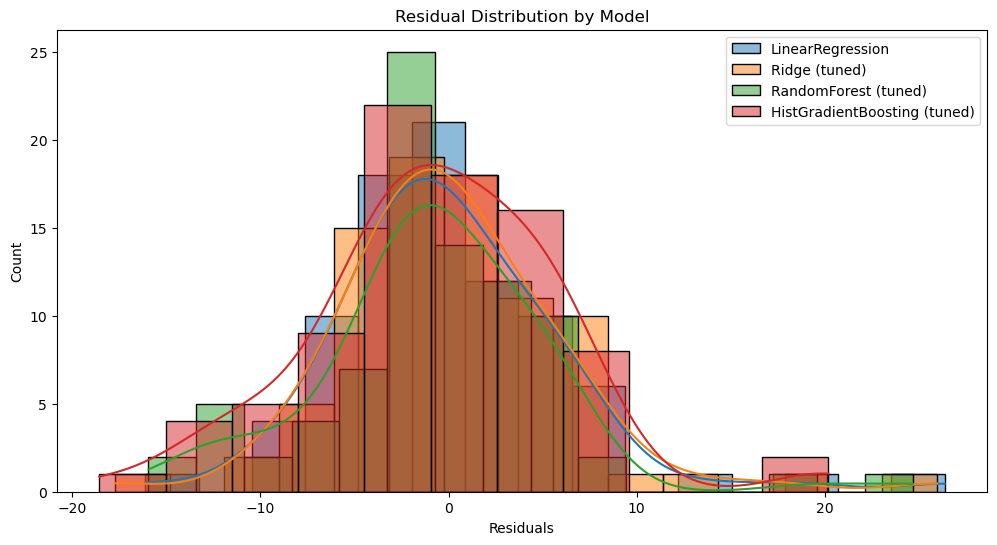

In [ ]:
plt.figure(figsize=(12, 6))
for model_name, preds in zip(test_results_df.index, [res['preds'] for res in results_on_test]):
    residuals = y_test - preds
    sns.histplot(residuals, kde=True, label=model_name, alpha=0.5)

plt.xlabel("Residuals")
plt.title("Residual Distribution by Model")
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# 7. Compare and choose best model
# -----------------------------

# Collect all models in one DataFrame
all_results = pd.concat([baseline_df, tuned_df])

# Sort by R2 (higher is better) or RMSE (lower is better)
best_model_r2 = all_results['r2'].idxmax()
best_model_rmse = all_results['rmse'].idxmin()

print("\n=== Model Comparison ===")
print(all_results)

print(f"\nBest model by R2: {best_model_r2} (R2={all_results.loc[best_model_r2, 'r2']:.4f})")
print(f"Best model by RMSE: {best_model_rmse} (RMSE={all_results.loc[best_model_rmse, 'rmse']:.4f})")

# Choose final model based on balance of metrics
# For predictive accuracy, prioritize RMSE; for interpretability, R2
chosen_model = best_model_rmse
print(f"\nChosen model for final predictions: {chosen_model}")


=== Model Comparison ===
                                   mae      rmse        r2
name                                                      
LinearRegression              0.321499  0.443634  0.796529
Ridge                         0.321377  0.443879  0.796304
RandomForest                  0.326791  0.444785  0.795472
HistGradientBoosting          0.382051  0.493325  0.748395
Ridge (tuned)                 0.325170  0.451551  0.789202
RandomForest (tuned)          0.323619  0.446970  0.793458
HistGradientBoosting (tuned)  0.361215  0.474146  0.767578

Best model by R2: LinearRegression (R2=0.7965)
Best model by RMSE: LinearRegression (RMSE=0.4436)

Chosen model for final predictions: LinearRegression


NameError: name 'best' is not defined

---
**1. Compliance/Audit Cluster (very high MI)**
- audit_score_q1
- audit_score_q2
- compliance_score_final
- operational_health_index
- overall_risk_score
- violations_past_3years
- reporting_lag_days

These variables represent the same underlying process, are collinear. We should Keep 1–2 (e.g., compliance_score_final + overall_risk_score) OR create a composite index (e.g., average or PCA component) to capture cluster without multicollinearity.


**2. Training/Engagement Cluster**
- training_hours_quarterly
- engagement_programs
- onboarding_program
- remediation_plan_active

Represents organizational effort. Training-related features are important and we expect them to be strong predictors. Keep them OR summarize into a “training/engagement score” through averaging or PCA.



**3. Structural + Resources Cluster**
- dept_age_years
- team_size
- manager_experience_level
- interdept_collaboration_score
- resource_availability_score

Represents department capacity. Consistency across MI suggests institutional culture effects. Keep them and standatdaze before modeling.


**4. ID-Driven / Latent Department Identity Cluster**
- dept_id

dept_id has strong MI with almost everything, which is misleading: MI sees uniqueness of the ID, not actual patterns. It may correlate with everything just because each row is distinct. That does not mean it’s a predictive feature — it’s an artifact.

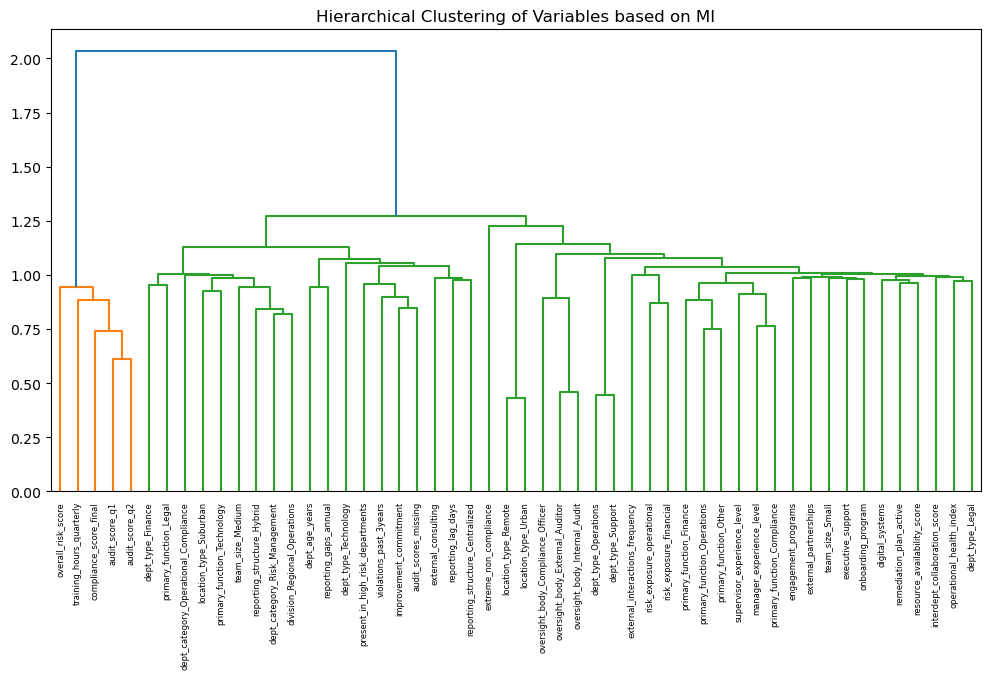

In [ ]:
'''
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Drop dept_id from MI matrix
mi_matrix_reduced = mi_matrix.drop(index='dept_id', columns='dept_id')

# Hierarchical clustering using average linkage
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(mi_matrix_reduced, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=mi_matrix_reduced.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Variables based on MI')
plt.show()
'''

In [ ]:
'''
X = mi_matrix_reduced.values  # each row = variable, each column = MI with other vars
'''

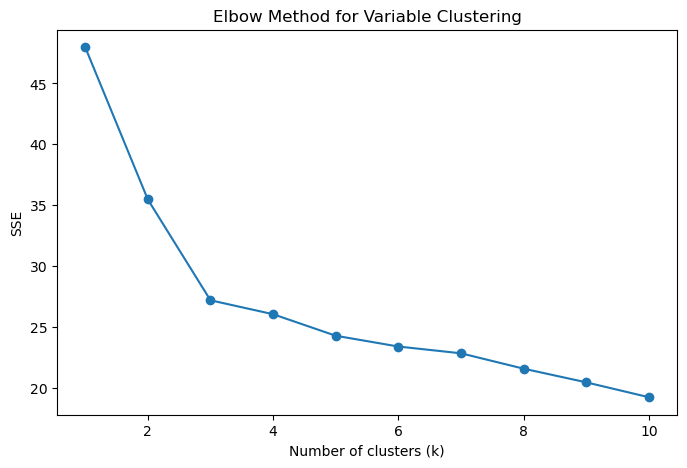

In [ ]:
'''
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # sum of squared distances within clusters

plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Variable Clustering')
plt.show()
'''

In [ ]:
'''
optimal_k = 5  # based on elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

var_clusters = pd.DataFrame({'variable': mi_matrix_reduced.columns, 'cluster': clusters})
print(var_clusters.sort_values('cluster'))
'''

                                variable  cluster
51         oversight_body_Internal_Audit        0
26                extreme_non_compliance        0
43           primary_function_Compliance        0
44              primary_function_Finance        0
19              operational_health_index        0
18               risk_exposure_financial        0
16       external_interactions_frequency        0
15           resource_availability_score        0
14         interdept_collaboration_score        0
13                 external_partnerships        0
40                       team_size_Small        0
12                       digital_systems        0
10                    onboarding_program        0
9                    engagement_programs        0
47                primary_function_Other        0
7                      executive_support        0
6                remediation_plan_active        0
2            supervisor_experience_level        0
1               manager_experience_level        0


In [ ]:
'''
representatives = []

for cluster_id in var_clusters['cluster'].unique():
    vars_in_cluster = var_clusters[var_clusters['cluster'] == cluster_id]['variable']
    # MI submatrix for variables in the cluster
    sub_mi = mi_matrix_reduced.loc[vars_in_cluster, vars_in_cluster]
    # Average MI for each variable with others in cluster
    avg_mi = sub_mi.mean(axis=1)
    # Pick variable with highest average MI
    representative = avg_mi.idxmax()
    representatives.append(representative)

print("Representative variables per cluster:")
print(representatives)
'''

Representative variables per cluster:
['reporting_gaps_annual', 'extreme_non_compliance', 'audit_score_q2', 'violations_past_3years', 'dept_type_Support']


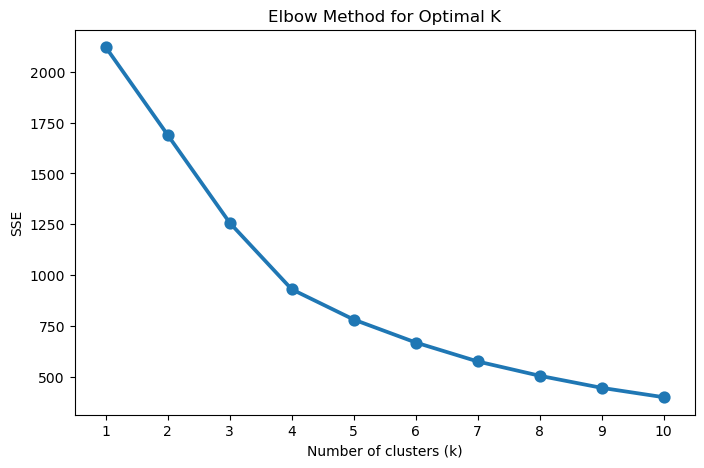

In [ ]:
'''
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Select MI-reduced variables
# -----------------------------
# Replace with your chosen representative variables per cluster
selected_vars = ['reporting_gaps_annual', 'extreme_non_compliance', 'audit_score_q2', 'violations_past_3years', 'dept_type_Support']


data_reduced = departments[selected_vars]

# -----------------------------
# 2. Standardize the variables
# -----------------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reduced)

# -----------------------------
# 3. Determine optimal number of clusters using Elbow Method
# -----------------------------
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8, 5))
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.show()

'''

In [ ]:
'''
optimal_k = 5
'''

In [ ]:
'''
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster labels to your dataframe
departments['cluster'] = clusters
departments[['dept_id', 'cluster'] + selected_vars].head()
'''

,dept_id,cluster,reporting_gaps_annual,extreme_non_compliance,audit_score_q2,violations_past_3years,dept_type_Support
0,DEPT-1003,4,-1.266665,0,0.204688,-0.429057,1
4,DEPT-1066,4,-0.177868,0,0.204688,-0.429057,1
5,DEPT-1070,1,1.541237,0,-0.558281,-0.429057,0
6,DEPT-1089,4,-1.266665,0,0.967658,-0.429057,1
8,DEPT-1096,2,-0.177868,0,-0.863469,3.046918,0


In [ ]:
'''
departments['cluster'].value_counts()
'''

cluster
1    158
0    124
4     96
2     44
3      2
Name: count, dtype: int64

In [ ]:
'''
departments.groupby('cluster')[selected_vars].mean()
'''

,reporting_gaps_annual,extreme_non_compliance,audit_score_q2,violations_past_3years,dept_type_Support
cluster,,,,,
0,0.549967,0.0,-0.377630,-0.185550,1.000000
1,-0.074734,0.0,-0.130391,-0.353258,0.000000
2,0.683621,0.0,0.556001,2.571163,0.295455
3,-1.266665,1.0,-1.130508,1.505815,0.000000
4,-0.874312,0.0,0.471092,-0.388747,1.000000


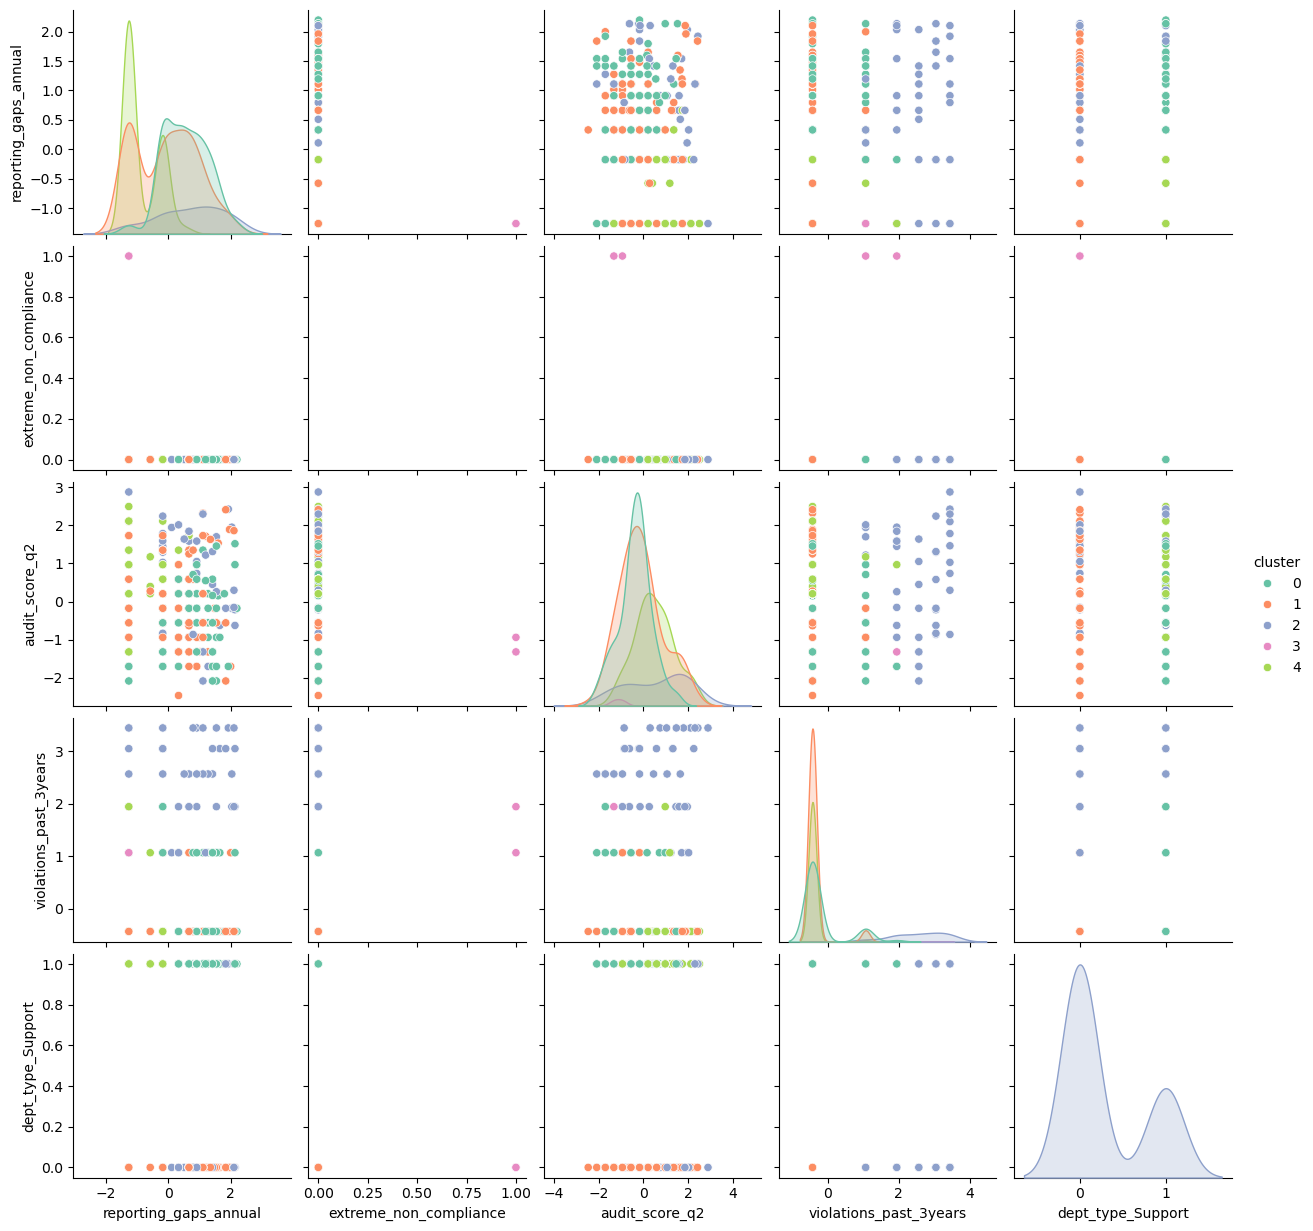

In [ ]:
'''
sns.pairplot(departments, vars=selected_vars, hue='cluster', palette='Set2')
plt.show()
'''

---
Now we can deduce dimentionality

---

In [ ]:
#don't touch compliance_score_final as it is our primary target
pca_features = [
    'dept_age_years', 'manager_experience_level', 'supervisor_experience_level',
    'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years',
    'reporting_gaps_annual', 'interdept_collaboration_score', 'resource_availability_score',
    'external_interactions_frequency', 'risk_exposure_operational', 'risk_exposure_financial',
    'operational_health_index', 'overall_risk_score', 'audit_score_q1', 'audit_score_q2'
]

In [ ]:
# Example: apply PCA on Compliance/Audit cluster
audit_features = ['audit_score_q1', 'audit_score_q2', 'overall_risk_score', 'operational_health_index', 'violations_past_3years', 'reporting_lag_days']
pca = PCA(n_components=1)  # reduce cluster to 1 component
df['audit_pca'] = pca.fit_transform(df[audit_features])

# Optional: drop original highly collinear features
df = df.drop(columns=audit_features)

df.head()

,dept_id,dept_age_years,manager_experience_level,supervisor_experience_level,training_hours_quarterly,remediation_plan_active,executive_support,external_consulting,engagement_programs,onboarding_program,improvement_commitment,digital_systems,external_partnerships,interdept_collaboration_score,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,reporting_gaps_annual,compliance_score_final,present_in_high_risk_departments,extreme_non_compliance,audit_scores_missing,dept_category_Operational_Compliance,dept_category_Risk_Management,division_Regional_Operations,dept_type_Finance,dept_type_Legal,dept_type_Operations,dept_type_Support,dept_type_Technology,location_type_Remote,location_type_Suburban,location_type_Urban,team_size_Medium,team_size_Small,reporting_structure_Centralized,reporting_structure_Hybrid,primary_function_Compliance,primary_function_Finance,primary_function_Legal,primary_function_Operations,primary_function_Other,primary_function_Technology,oversight_body_Compliance_Officer,oversight_body_External_Auditor,oversight_body_Internal_Audit,audit_pca
0,DEPT-1003,0.733198,-1.486610,-0.344146,0.057076,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.187074,0.819720,0.817431,-0.570093,-1.029951,-1.266665,0.064613,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,-0.172802
4,DEPT-1066,-1.089808,0.306627,1.502915,0.973154,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.176393,-1.160686,-0.964526,-0.570093,-1.029951,-0.177868,0.064613,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,-0.829840
5,DEPT-1070,-0.396733,0.306627,-0.344146,-1.485584,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,-0.834289,-0.170483,0.817431,1.282164,2.050820,1.541237,-0.303316,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0.197116
6,DEPT-1089,0.203635,1.203245,1.502915,0.057076,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.176393,-1.160686,0.817431,-0.570093,-1.029951,-1.266665,0.800471,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,-0.123752
8,DEPT-1096,0.203635,-1.486610,-2.191206,1.710861,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.187074,1.809923,-1.855505,2.208292,1.280627,-0.177868,-0.965587,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,3.199606


In [ ]:
MAIIA
1. Split data into train and test
2. Three models to try

	1.	Linear Regression (baseline)
	2.	Random Forest Regressor (tree-based, non-linear)
	3.	Gradient Boosting (XGBoost or HistGradientBoosting)
3. compare them, evaluate, analyze
4. Hyperparameter optimization: possibly 5-folds cross-validation. list best parameters for each model.
5. compare models again. briefly explain which model we choose as the best and why

FILIPPA
1. look at multicolinearity again. there should be multicolinearity.
2. Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing

EVELINA
1.Look at the MI analysis section, it is very connected to multicolinearity. Do you think it makes sense? please double check after me MI and skeweness standardizing
2.Start writing README. Think how we can deliver out project creatively, not like others. Consider adding mindmaps, nice graphs, etc. Think how we could stand out
